In [2]:
# VGG16 기반 접촉감지 Model 생성
# tensorflow 2.16.1 / keras 3.3.3

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.imagenet_utils import decode_predictions 
import numpy as np
import math

In [4]:
TRAIN_DATA_DIR = './train/image'
VALIDATION_DATA_DIR = './valid/image'
TEST_DATA_DIR = './test/image'
 
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

In [5]:
# Input 데이터 가공
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   vertical_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 8792 images belonging to 2 classes.
Found 2681 images belonging to 2 classes.


In [5]:
def model_maker(num_train_layer):
    base_model = VGG16(weights='imagenet', include_top=False, 
                       input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)) # top 제외

    # fine tuning
    for layer in base_model.layers[:-(num_train_layer)]:
        layer.trainable = False # num_train_layer 값만큼의 층을 새롭게 학습 

    input1 = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input1)
    custom_model = Flatten()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    predictions = Dense(2, activation='softmax')(custom_model) 
    return Model(inputs=input1, outputs=predictions)

In [6]:
# train Model
checkpoint_filepath = "./model1_layer3_monitorLoss_Adam.keras"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

num_train_layer = 3
model = model_maker(num_train_layer)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
history=model.fit(
    train_generator,
    epochs= 200,
    validation_data=validation_generator, callbacks=[es, mc])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,320,514 (62.26 MB)

 Trainable params: 6,325,442 (24.13 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

Epoch 1/200


C:\Users\hybyu\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 795s 6s/step - acc: 0.7861 - loss: 1.8349 - val_acc: 0.2193 - val_loss: 0.6999
Epoch 2/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 751s 5s/step - acc: 0.6772 - loss: 0.6717 - val_acc: 0.7807 - val_loss: 0.6168
Epoch 3/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 749s 5s/step - acc: 0.8134 - loss: 0.5922 - val_acc: 0.7807 - val_loss: 0.5746
Epoch 4/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 749s 5s/step - acc: 0.8143 - loss: 0.5470 - val_acc: 0.7807 - val_loss: 0.5507
Epoch 5/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 749s 5s/step - acc: 0.8215 - loss: 0.5139 - val_acc: 0.7807 - val_loss: 0.5373
Epoch 6/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 750s 5s/step - acc: 0.8221 - loss: 0.4958 - val_acc: 0.7807 - val_loss: 0.5304
Epoch 7/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 756s 5s/step - acc: 0.8166 - loss: 0.4906 - val_acc: 0.7807 - val_loss: 0.5272
Epoch 8/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 749s 5s/step - acc: 0.8116 - loss: 0.4902 - val_acc: 0.7807 - val_loss: 0.5261
Epoch 9/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 749s 5s/ste

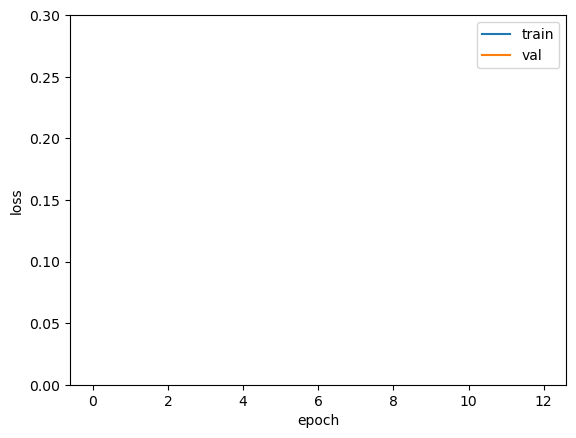

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.ylim([0, 0.3])  
plt.show()

In [8]:
# test Model
test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

best_model = models.load_model(checkpoint_filepath) # best model 불러오기
model = best_model

model.evaluate(test_generator, steps=math.ceil(float(1155 / BATCH_SIZE)),verbose=1) 

Found 1155 images belonging to 2 classes.
19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - acc: 0.5010 - loss: 0.8739


[0.5246894359588623, 0.7818182110786438]

In [9]:
# train Model
checkpoint_filepath = "./model1_layer3_monitorLoss_RMSprop.keras"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

num_train_layer = 3
model = model_maker(num_train_layer)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(0.001),
              metrics=['acc'])
history=model.fit(
    train_generator,
    epochs= 200,
    validation_data=validation_generator, callbacks=[es, mc])


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,320,514 (62.26 MB)

 Trainable params: 6,325,442 (24.13 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

Epoch 1/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 750s 5s/step - acc: 0.7681 - loss: 89.9631 - val_acc: 0.9336 - val_loss: 0.1958
Epoch 2/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 748s 5s/step - acc: 0.8486 - loss: 2.0303 - val_acc: 0.7807 - val_loss: 0.5102
Epoch 3/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 748s 5s/step - acc: 0.8608 - loss: 0.7254 - val_acc: 0.9787 - val_loss: 0.5241
Epoch 4/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 748s 5s/step - acc: 0.9708 - loss: 0.1373 - val_acc: 0.9549 - val_loss: 0.4056
Epoch 5/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 749s 5s/step - acc: 0.9924 - loss: 0.0442 - val_acc: 0.7702 - val_loss: 4.6973
Epoch 6/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 748s 5s/step - acc: 0.9616 - loss: 2.5652 - val_acc: 0.9855 - val_loss: 0.8887
Epoch 6: early stopping


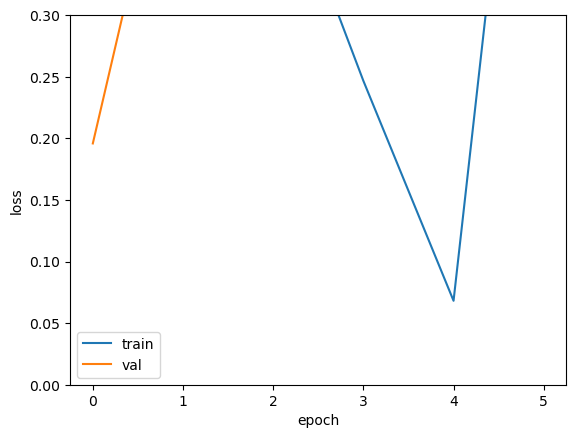

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.ylim([0, 0.3])  
plt.show()

In [11]:
# test Model
test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

best_model = models.load_model(checkpoint_filepath) # best model 불러오기
model = best_model

model.evaluate(test_generator, steps=math.ceil(float(1155 / BATCH_SIZE)),verbose=1) 

Found 1155 images belonging to 2 classes.
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - acc: 0.7580 - loss: 0.5105


[0.31569981575012207, 0.8813852667808533]

In [12]:
# train Model
checkpoint_filepath = "./model1_layer5_monitorLoss_Adam.keras"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

num_train_layer = 5
model = model_maker(num_train_layer)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
history=model.fit(
    train_generator,
    epochs= 200,
    validation_data=validation_generator, callbacks=[es, mc])


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,320,514 (62.26 MB)

 Trainable params: 8,685,250 (33.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 782s 6s/step - acc: 0.7533 - loss: 2.1054 - val_acc: 0.7807 - val_loss: 0.5469
Epoch 2/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 780s 6s/step - acc: 0.8168 - loss: 0.5031 - val_acc: 0.7807 - val_loss: 0.5261
Epoch 3/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 779s 6s/step - acc: 0.8125 - loss: 0.4840 - val_acc: 0.7807 - val_loss: 0.5290
Epoch 4/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 780s 6s/step - acc: 0.8149 - loss: 0.4790 - val_acc: 0.7807 - val_loss: 0.5300
Epoch 5/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 784s 6s/step - acc: 0.8156 - loss: 0.4780 - val_acc: 0.7807 - val_loss: 0.5303
Epoch 6/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 786s 6s/step - acc: 0.8126 - loss: 0.4828 - val_acc: 0.7807 - val_loss: 0.5296
Epoch 7/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 780s 6s/step - acc: 0.8155 - loss: 0.4782 - val_acc: 0.7807 - val_loss: 0.5305
Epoch 7: early stopping


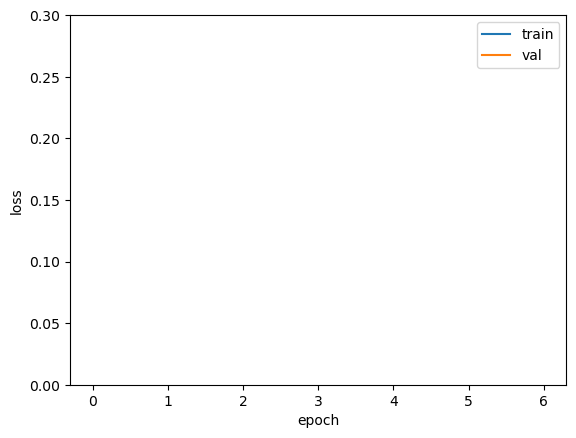

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.ylim([0, 0.3])  
plt.show()

In [14]:
# test Model
test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

best_model = models.load_model(checkpoint_filepath) # best model 불러오기
model = best_model

model.evaluate(test_generator, steps=math.ceil(float(1155 / BATCH_SIZE)),verbose=1) 

Found 1155 images belonging to 2 classes.
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - acc: 0.5010 - loss: 0.8835


[0.5245974659919739, 0.7818182110786438]

In [15]:
# train Model
checkpoint_filepath = "./model1_layer5_monitorLoss_RMSprop.keras"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

num_train_layer = 5
model = model_maker(num_train_layer)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(0.001),
              metrics=['acc'])
history=model.fit(
    train_generator,
    epochs= 200,
    validation_data=validation_generator, callbacks=[es, mc])


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,320,514 (62.26 MB)

 Trainable params: 8,685,250 (33.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 783s 6s/step - acc: 0.7615 - loss: 129.3620 - val_acc: 0.7807 - val_loss: 0.5535
Epoch 2/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 778s 6s/step - acc: 0.8222 - loss: 0.4967 - val_acc: 0.7807 - val_loss: 0.5280
Epoch 3/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 801s 6s/step - acc: 0.8175 - loss: 0.4754 - val_acc: 0.7807 - val_loss: 0.5298
Epoch 4/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 840s 6s/step - acc: 0.8120 - loss: 0.4835 - val_acc: 0.7807 - val_loss: 0.5296
Epoch 5/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 846s 6s/step - acc: 0.8132 - loss: 0.4817 - val_acc: 0.7807 - val_loss: 0.5325
Epoch 6/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 856s 6s/step - acc: 0.8182 - loss: 0.4743 - val_acc: 0.7807 - val_loss: 0.5302
Epoch 7/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 779s 6s/step - acc: 0.8129 - loss: 0.4822 - val_acc: 0.7807 - val_loss: 0.5299
Epoch 7: early stopping


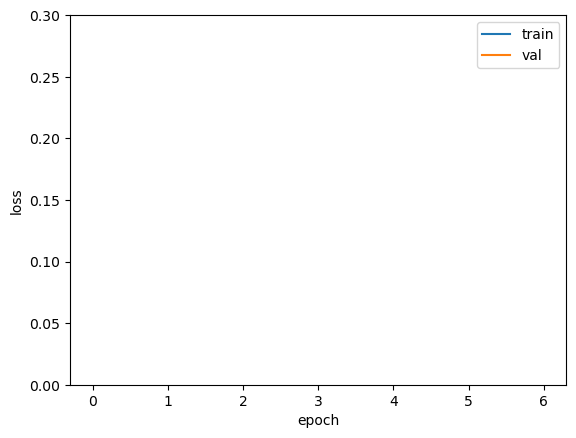

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.ylim([0, 0.3])  
plt.show()

In [1]:
# test Model
test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

best_model = models.load_model(checkpoint_filepath) # best model 불러오기
model = best_model

model.evaluate(test_generator, steps=math.ceil(float(1155 / BATCH_SIZE)),verbose=1) 


NameError: name 'val_datagen' is not defined

In [ ]:
checkpoint_filepath = "./model1_layer5_monitorLoss_RMSprop.keras"
model.matrx_names